# Лабораторная работа №2. Дискриминантный анализ.


### 1. Подготовка библиотек
Импортируем необходимые библиотеки:

In [1]:
import numpy as np # поддерживает матрицы, массивы, мат.функции для них
import pandas as pd # библиотека для анализа данных
from scipy.stats import f
from scipy.spatial.distance import mahalanobis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### 2. Преддискриминантный этап анализа
Целью дискриминантного анализа является разделение рассматриваемой совокупности объектов или явлений на заданные обучающими выборками классы. Исходные данные для анализа представлены в виде матрицы.

Есть два способа создания тренировочной выборки - с помощью списка TRAIN_SAMPLES или заполнение вручную стобца в Excel-файле.

In [2]:
_ = \
"""
    Что поменять:
        0) названия файлов, для считывания и для записи(этот в самом конце)
        1) FEATURES
        2) задать TRAIN_SAMPLES, если не задается, то удалить параметр из вызова функции gen_train_data
        3) задать F to enter в sda
"""

In [3]:
# В переменную FEATURES записываем названия показателей
FEATURES = ["x1", "x2", "x3", "x4", "x5"] 

# создаем словарь - для каждого класса перечисляем номера объектов тренировочной выборки в зависимости от варианта

TRAIN_SAMPLES = {
    1 : [5,9,12,15,20,24,26,34],
    2 : [42, 44],
    3 : [2,5,11,22,25,29,31,35],
}

In [4]:
data = pd.read_excel("C:\Games\Ekonometrika\data_for_lab2_part2_1.xlsx") # считываем данные из файла (файл, который содержит ВСЕ строки и ВСЕ признаки)
data.head() #по умолчанию метод head выведет первые 5 строк

,x1,x2,x3,x4,x5,x6
1,20.8,58.5,69,15626,0.1,NaN
2,12.4,93.0,180,23410,1.4,3.0
3,11.9,39.8,224,9855,0.7,NaN
4,13.6,55.0,116,4881,0.2,3.0
5,17.2,63.5,172,15466,5.3,1.0


Создаем новую переменную, в которую будем записывать все данные, которые необходимо включить в итоговый Excel-файл.

In [5]:
data_to_excel = data[FEATURES]

Далее, вводим функцию gen_train_data по созданию тренировочной выборки.
<br>Аргументы функции: 
- data - данные для анализа
- features - названия признаков 
- train_samples - опциональный параметр: если он передан, то разбиение классов обучающей выборкой задается при помощи train_samples (1 часть ЛР), в противном случае разбиение должно присутствовать в одном из столбцов data (2 часть ЛР)

In [6]:
def gen_train_data(data, features, train_samples=None):
    if train_samples: # если опциональный параметр задан
        train_data = pd.DataFrame() # создаем тренировочную выборку, пока пустую
        for cls, samples in train_samples.items(): # в cls записываем номера классов, в samples список объектов этого класса
            train_samps = data[features].loc[samples] # выбираем объекты обучающей выборки
            train_samps["Class"] = cls # добавляем к ним колонку с номером класса
            train_data = pd.concat([train_data, train_samps]) # concat - функция объединения таблиц
    else:
        assert data.shape[1] == len(features) + 1 # если в исходном файле нет доп.колонки с разбиением, выдаст ошибку
        train_data = data.dropna() # берем в тренировочную выборку только те строки, где проставлены классы
        cls_col = train_data.drop(columns=features).columns[0] 
        train_data = train_data.rename({cls_col: "Class"}, axis=1) # переименовываем колонку с обучающей выборкой на  "Class"
    train_data = train_data.astype({"Class": 'int32'}) # присваем колонке "Class" тип int
    return train_data

In [7]:
# если классы заданы в файле - TRAIN_SAMPLES надо удалить
train_data = gen_train_data(data, FEATURES)
train_data.head() # смотрим результаты работы функции gen_train_data

,x1,x2,x3,x4,x5,Class
2,12.4,93.0,180,23410,1.4,3
4,13.6,55.0,116,4881,0.2,3
5,17.2,63.5,172,15466,5.3,1
9,17.7,75.3,77,28919,0.2,1
11,11.7,51.4,69,7589,7.9,3


Добавим столбец с обучающей выборкой в переменную.

In [8]:
data_to_excel["Train sample"] = train_data.Class

Для расчета Лямбды Уилкса необходимо знать: <br>
1) общая матрица рассеяния: 
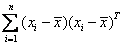

2) внутриклассовые матрицы разброса
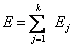

где 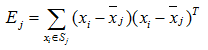

In [9]:
# проведем расчет матрицы рассеяния 

def scatter_matrix(samples):
    if isinstance(samples, pd.Series):
        samples = samples.to_frame()
    d = samples - samples.mean()
    res = np.zeros((d.shape[1], d.shape[1]))
    for _, row in d.iterrows():
        col = row.to_frame()
        res += col @ col.T
    return res

In [10]:
# проведем расчет внутриклассовых матриц разброса

def classes_scatter_matrix(samples, labels):
    A = np.zeros((samples.shape[1], samples.shape[1])) #создаем массив с нулями
    for cls in labels.unique(): #находит уникальные значения
        A += scatter_matrix(samples[labels == cls])
    return A

Рассчитаем ковариационную матрицу:

In [11]:
# выведем ковариационную матрицу
# она рассчитывается как классовая матрица рассеяния "classes_scatter_matrix", деленная на (кол-во объектов - кол-во классов)

cov = pd.DataFrame(
    classes_scatter_matrix(train_data[FEATURES], train_data.Class) / (train_data.shape[0] - train_data.Class.unique().size), 
    index=FEATURES, 
    columns=FEATURES
)

cov

,x1,x2,x3,x4,x5
x1,0.972583,-2.306000,-4.034167e+00,-3.415050e+02,-1.730917
x2,-2.306000,228.072333,-2.928500e+02,1.228396e+05,-32.641667
x3,-4.034167,-292.850000,2.122649e+04,-2.142470e+06,1807.107500
x4,-341.505000,122839.590000,-2.142470e+06,2.966591e+08,-194841.238333
x5,-1.730917,-32.641667,1.807107e+03,-1.948412e+05,179.418500


Для проведения дискриминантного анализа используем возможности класса LinearDiscriminantAnalysis.

In [12]:
# "обучаем" модель с помощью метода fit класса LinearDiscriminantAnalysis 
# в метод fit передаем исходные данные
lda = LinearDiscriminantAnalysis().fit(train_data[FEATURES], train_data.Class)

Рассчитаем оценки математических ожиданий в классах.

In [13]:
# выведем средние значения параметров для каждого класса обучающей выборки
means = pd.DataFrame(lda.means_, index=lda.classes_, columns=FEATURES)
means

,x1,x2,x3,x4,x5
1,16.4500,70.55,136.000,16821.50,4.6875
2,16.6000,114.05,567.500,59785.50,121.6000
3,13.0875,75.10,115.875,15918.25,4.7125


### 3.	Дискриминантный анализ

Определим линейные дискриминантные функции Фишера.
Зададим функцию вывода коэффициентов функции Фишера.

In [14]:
def get_df_coef(lda, features):
    if lda.classes_.size == 2: #если 2 класса, то lda вернет разность коэффициентов функций
        return pd.DataFrame(
            np.concatenate([lda.intercept_, lda.coef_.ravel()]), #хз, 
            index=["Intercept"] + features,
            columns=["Discriminant F"]
        )
# если 3 и более классов, то lda вернет несколько функций (аналогично ППП Statistica)
    return pd.DataFrame(
        np.vstack([lda.intercept_, lda.coef_.T]),
        index=["Intercept"] + features,
        columns=lda.classes_
    )

In [15]:
df_coef = get_df_coef(lda, FEATURES) # применим эту функцию для наших параметров
df_coef

,1,2,3
Intercept,-11.455689,-423.228453,45.111224
x1,0.868085,8.154125,-2.906616
x2,0.055209,-0.557163,0.084082
x3,0.012508,-0.106458,0.014107
x4,-0.000225,0.002340,-0.000360
x5,-0.424308,4.169994,-0.618191


Зададим функцию расчета квадратов расстояний Махаланобиса между классами, где:
 - centers - центры классов
 - samples - объекты, для которых считаем расстояния
 - cov - ковариационная матрицы

In [16]:
def calc_mahalanobis_square_dist(centers, samples, cov):
    # создаем матрицу расстояний между классами и объекnами
    res = pd.DataFrame(index=samples.index, columns=centers.index)
    for i in centers.index: # проходим по всем центрам классов
        for j in samples.index: # проходим по всем объектам
            # считаем расстояние между текущим классом и объектом
            res[i][j] = mahalanobis(centers.loc[i], samples.loc[j], np.linalg.inv(cov)) ** 2 
    return res

In [17]:
# выведем квадраты расстояний Махаланобиса между классами
center_distance = calc_mahalanobis_square_dist(means, means, cov)
center_distance

,1,2,3
1,0,570.458,12.9088
2,570.458,0,637.554
3,12.9088,637.554,0


Выведем оценки априорных вероятностей:

In [18]:
lda.priors_ 

array([0.44444444, 0.11111111, 0.44444444])

Далее, определим функцию вывода номеров классов для переданных X:

In [19]:
def LDA_predict(lda, X):
    return pd.DataFrame(
        lda.predict(X),
        columns=["Class"],
        index=X.index
    )

Поведем повторную классификацию объектов тренировочной выборки:

In [20]:
lda_predict_train = LDA_predict(lda, train_data[FEATURES])
# сравниваем полученные классы с теми, которые были заданы в начале, и смотрим долю совпадения
(lda_predict_train.Class == train_data.Class).value_counts(normalize=True)

True    1.0
Name: Class, dtype: float64

Получим полную картину классификации всех объектов:

In [21]:
lda_predict = LDA_predict(lda, data[FEATURES])
lda_predict.head()
print(lda_predict)

    Class
1       1
2       3
3       3
4       3
5       1
6       3
7       1
8       1
9       1
10      1
11      3
12      1
13      1
14      2
15      1
16      1
17      1
18      1
19      1
20      1
21      3
22      3
23      2
24      1
25      3
26      1
27      3
28      1
29      3
30      1
31      3
32      3
33      3
34      1
35      3
36      1
37      1
38      2
39      1
40      1
41      1
42      2
43      1
44      2
45      3
46      3
47      3


Запишем результаты классификации в переменную.

In [22]:
data_to_excel["Results lda"] = lda_predict

Выведем квадраты расстояний Махаланобиса между классами и объектами:

In [23]:
samp_dist = calc_mahalanobis_square_dist(means, data[FEATURES], cov)
samp_dist.head()
print(samp_dist)

           1        2        3
1    21.8561  546.512   66.413
2    24.2327   688.08  5.63526
3    47.9922  740.409  24.6164
4    16.0357  706.711  3.42337
5    1.33152  562.118  20.0655
6     10.753  654.881  8.47284
7    11.3442  591.705  43.6299
8    7.95404  540.752  37.1539
9    2.98299  526.177  26.7725
10   22.7777  442.549  32.7601
11   29.1642   647.29  6.28389
12   5.55532  667.983  10.8848
13   10.6162  646.454  22.6697
14   217.862  188.214  232.061
15   3.07666  540.032  13.5065
16   27.1068  406.281  59.8527
17   5.54992  599.447  24.3585
18   55.4946  362.598  78.1241
19   81.5448  329.411   125.25
20   1.71936  600.804  5.38642
21   152.601  421.481  147.131
22   24.1987    599.6   4.8588
23   319.199  162.598  338.657
24    1.9069  538.917  23.7026
25   10.1459  563.542  5.35462
26   6.64653  561.004  15.9446
27   17.3097  665.947  10.9342
28   39.1669   603.93  72.9505
29   10.0672  688.232  4.71991
30   34.7816  556.213  66.5082
31   16.5233  594.995  1.65143
32   68.

In [24]:
data_to_excel = pd.concat([data_to_excel, samp_dist.add_prefix("lda mahalanobis ")], axis=1)

Зададим функцию для вывода апостериорных вероятностей:

In [25]:
def LDA_predict_proba(lda, X):
    return pd.DataFrame(
        lda.predict_proba(X),
        columns=lda.classes_,
        index=X.index
    )

Применим функцию LDA_predict_proba для наших данных:

In [26]:
lda_post_prob = LDA_predict_proba(lda, data[FEATURES])
lda_post_prob.head()
print(lda_post_prob)

               1              2             3
1   9.999997e-01  3.713101e-112  2.654311e-07
2   4.108247e-01  2.387588e-145  5.891753e-01
3   4.431163e-01  2.386399e-151  5.568837e-01
4   4.936277e-01  5.144863e-150  5.063723e-01
5   9.973547e-01  1.307393e-121  2.645274e-03
6   4.942529e-01  4.980774e-140  5.057471e-01
7   9.998230e-01  4.296605e-124  1.770416e-04
8   9.999699e-01  3.328679e-115  3.014983e-05
9   9.999149e-01  7.646950e-114  8.509544e-05
10  9.932368e-01   1.751894e-92  6.763201e-03
11  6.150709e-02  9.816068e-137  9.384929e-01
12  5.075683e-01  7.896784e-143  4.924317e-01
13  6.592566e-01  6.197683e-137  3.407434e-01
14  1.458583e-06   9.999985e-01  1.204392e-09
15  9.879204e-01  1.410795e-117  1.207960e-02
16  9.999999e-01   1.184026e-83  7.968216e-08
17  9.845443e-01  5.186990e-128  1.545574e-02
18  9.999878e-01   5.143275e-68  1.219216e-05
19  1.000000e+00   3.753750e-55  3.233671e-10
20  6.050343e-01  1.216302e-130  3.949657e-01
21  6.092777e-02   6.254661e-61  9

In [27]:
data_to_excel = pd.concat([data_to_excel, lda_post_prob.add_prefix("lda post prob ")], axis=1)

### 4.	Пошаговый дискриминантный анализ

Зададим функцию расчета Лямбды Уилкса:

In [28]:
def wilks_lambda(samples, labels):
    if isinstance(samples, pd.Series):
        samples = samples.to_frame()
    dT = np.linalg.det(scatter_matrix(samples)) # расчет определителя матрицы рассеяния
    dE = np.linalg.det(classes_scatter_matrix(samples, labels)) # расчет определителя матрицы классового рассеяния
    return dE / dT # их частное и есть Лямбда Уилкса

Зададим функцию расчета f value и p value :
- lmbda - Лямбда Уилкса
- n_obs - кол-во объектов
- n_var - кол-во признаков
- n_cls - кол-во классов

In [29]:
def f_value_wilks_lambda(lmbda, n_obs, n_var, n_cls):
    num = (1 - lmbda) * (n_obs - n_cls - n_var)
    den = lmbda * (n_cls - 1)
    f_value = num / den #значение статистики Фишера
    # f.sf считает p value для определенного значения статистики Фишера и заданных степеней свободы
    p_value = f.sf(f_value, n_cls - 1, n_obs - n_cls - n_var) 
    return f_value, p_value

sda - функция для проведения пошагового дискриминантного анализа:
 - samples - набор объектов
 - labels - названия классов
 - F_in=1e-4 - установленное нами значение F_to_Enter
Функция выводит для каждого шага переменные в модели(into) и вне модели(out) и их характеристики.

In [30]:
def sda(samples, labels, F_in = 28.25):
    stat_columns = ["Wilk's lambda", "Partial lambda", "F to enter", "p-value"]
    n_cls = labels.unique().size # количество классов
    n_obs = samples.shape[0] # количество объектов
    
    # словари для вывода переменных в модели и вне модели на каждом шаге
    out = {0: pd.DataFrame(columns=stat_columns, index=samples.columns, dtype=float)} 
    into = {0: pd.DataFrame(columns=stat_columns, dtype=float)}
    
    step = 0
    while True:
        model_lambda = wilks_lambda(samples[into[step].index], labels) #посчитали Лямбду Уилкса для модели на данном шаге
        
        for x in out[step].index: # проходим по переменным вне модели на данном шаге
        # далее рассчитываем характеристики для данных переменных и записываем их в таблицу    
            lmbda = wilks_lambda(samples[into[step].index.tolist() + [x]], labels) 
            partial_lambda = lmbda / model_lambda
            f_lambda, p_value = f_value_wilks_lambda(partial_lambda, n_obs, into[step].index.size, n_cls)
            out[step].loc[x] = lmbda, partial_lambda, f_lambda, p_value 
            
        for x in into[step].index: # проходим по переменным в модели на данном шаге
        # далее рассчитываем характеристики для данных переменных и записываем их в таблицу  
            lmbda = wilks_lambda(samples[into[step].index.drop(x)], labels)
            partial_lambda = model_lambda / lmbda
            f_lambda, p_value = f_value_wilks_lambda(partial_lambda, n_obs, into[step].index.size - 1, n_cls)
            into[step].loc[x] = lmbda, partial_lambda, f_lambda, p_value
            
        # критерий для остановки цикла 
        # если вне модели нет переменных ИЛИ новая переменная обладает f_to_enter меньше порогового значения, цикл остановлен
        if out[step].index.size == 0 or out[step]["F to enter"].max() < F_in:
            break
        
        # ищем элемент с max f_to_enter
        x_to_enter = out[step]["F to enter"].idxmax()
        # переносим его из элементов "вне модели" в элементы "в модели"
        into[step + 1] = into[step].append(out[step].loc[x_to_enter])
        out[step + 1] = out[step].drop(index=x_to_enter)
        
        step += 1 # переходим к следующему шагу
        
    return into, out 

Вызываем результаты работы заданной выше функции:

In [31]:
into, out = sda(train_data[FEATURES], train_data.Class, 2.2)

Выводим результаты работы для переменных "в модели" на экран:

In [32]:
for i, t in into.items():
    print("Step ", i)
    print(t, end="\n\n")

Step  0
Empty DataFrame
Columns: [Wilk's lambda, Partial lambda, F to enter, p-value]
Index: []

Step  1
    Wilk's lambda  Partial lambda  F to enter       p-value
x5            1.0         0.09973    67.70322  3.098748e-08

Step  2
    Wilk's lambda  Partial lambda  F to enter       p-value
x5       0.570198        0.034736  194.521893  6.101416e-11
x4       0.099730        0.198599   28.246958  1.218526e-05

Step  3
    Wilk's lambda  Partial lambda  F to enter       p-value
x5       0.132079        0.033439  187.886644  2.556260e-10
x4       0.023394        0.188790   27.929711  1.967297e-05
x1       0.019806        0.222988   22.649611  5.805289e-05



Выводим результаты работы для переменных "вне модели" на экран:

In [33]:
for i, t in out.items():
    print("Step ", i)
    print(t, end="\n\n")

Step  0
    Wilk's lambda  Partial lambda  F to enter       p-value
x1       0.221794        0.221794   26.315154  1.243438e-05
x2       0.524286        0.524286    6.805175  7.884254e-03
x3       0.477612        0.477612    8.203113  3.918017e-03
x4       0.570198        0.570198    5.653334  1.479758e-02
x5       0.099730        0.099730   67.703220  3.098748e-08

Step  1
    Wilk's lambda  Partial lambda  F to enter   p-value
x1       0.023394        0.234572   22.841526  0.000039
x2       0.080912        0.811309    1.628028  0.231369
x3       0.031643        0.317289   15.061906  0.000324
x4       0.019806        0.198599   28.246958  0.000012

Step  2
    Wilk's lambda  Partial lambda  F to enter   p-value
x1       0.004417        0.222988   22.649611  0.000058
x2       0.015535        0.784363    1.786981  0.206234
x3       0.016756        0.845997    1.183245  0.337207

Step  3
    Wilk's lambda  Partial lambda  F to enter   p-value
x2       0.003711        0.840163    1.141470

Выводим названия признаков в модели:

In [34]:
stepwise_features = into[len(into) - 1].index.tolist()
stepwise_features

['x5', 'x4', 'x1']

Проводим дискриминантный анализ для отобранных признаков.

In [35]:
stepwise_lda = LinearDiscriminantAnalysis().fit(train_data[stepwise_features], train_data.Class)

 Выводим коэффициенты функции Фишера на экран.

In [36]:
stepwise_df_coef = get_df_coef(stepwise_lda, stepwise_features)
stepwise_df_coef

,1,2,3
Intercept,-9.334832,-392.164509,48.850303
x5,-0.271714,2.790984,-0.426032
x4,-0.000192,0.001972,-0.000301
x1,0.968417,7.333100,-2.801692


Пполучим полную картину классификации всех объектов.

In [37]:
stepwise_lda_predict = LDA_predict(stepwise_lda, data[stepwise_features])
stepwise_lda_predict.head()
print(stepwise_lda_predict)

    Class
1       1
2       3
3       3
4       3
5       1
6       3
7       1
8       1
9       1
10      1
11      3
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      3
22      3
23      2
24      1
25      3
26      1
27      3
28      1
29      3
30      1
31      3
32      3
33      3
34      1
35      3
36      1
37      1
38      2
39      1
40      1
41      1
42      2
43      1
44      2
45      3
46      3
47      3


Запишем результаты классификации в переменную.

In [38]:
data_to_excel["Results stepwise lda"] = stepwise_lda_predict

In [39]:
stepwise_cov = classes_scatter_matrix(train_data[stepwise_features], train_data.Class) \
    / (train_data.shape[0] - train_data.Class.unique().size)

stepwise_means = pd.DataFrame(stepwise_lda.means_, index=stepwise_lda.classes_, columns=stepwise_features)

stepwise_samp_dist = calc_mahalanobis_square_dist(stepwise_means, data[stepwise_features], stepwise_cov)
stepwise_samp_dist.head()
print(stepwise_samp_dist)

           1        2         3
1    19.6957   449.58   63.5912
2    18.0128  513.176  0.664489
3    28.1488  592.622   3.86643
4    15.8026  583.223    3.1025
5   0.614086  445.164   18.9349
6    5.86388  528.283   3.01587
7    9.32817  479.423   41.5437
8    4.92711  453.505   32.7069
9    2.89412  414.103   26.3367
10   5.58066  374.675    13.906
11   26.8484  559.571   2.78737
12   1.66527  503.229   8.14587
13  0.110126  456.545   14.3838
14   92.2896  168.457   100.197
15  0.313958  450.231   9.39475
16   9.37776  358.467   39.4105
17   2.65921  503.696   20.2083
18   21.1861  292.467   39.9365
19   34.5217  263.893   76.1037
20   1.59545  474.557   5.37663
21   74.1298  267.826   65.0369
22   22.3874  460.969   3.75484
23    133.99  125.028   146.191
24   1.66176  427.535   22.9958
25   9.02891  433.197   4.22005
26  0.435067  437.613   10.1575
27   10.8144  562.777   3.03179
28   10.4295  448.574   45.6333
29   9.85635  567.581   4.54388
30   8.32053   411.46     41.15
31   16.

In [40]:
data_to_excel = pd.concat([data_to_excel, stepwise_samp_dist.add_prefix("stepwise lda mahalanobis ")], axis=1)

In [41]:
stepwise_lda_post_prob = LDA_predict_proba(stepwise_lda, data[stepwise_features])
stepwise_lda_post_prob.head()
print(stepwise_lda_post_prob)

               1              2             3
1   9.999993e-01   2.683277e-91  7.031496e-07
2   9.057177e-02  7.534997e-110  9.094282e-01
3   3.449154e-01  4.858879e-124  6.550846e-01
4   4.858852e-01  1.349880e-123  5.141148e-01
5   9.979710e-01   1.417648e-96  2.028963e-03
6   4.856332e-01  5.965338e-114  5.143668e-01
7   9.998317e-01  3.466848e-100  1.683474e-04
8   9.998245e-01   1.849540e-96  1.754746e-04
9   9.999188e-01   1.273525e-89  8.116392e-05
10  9.842254e-01   1.803296e-81  1.577462e-02
11  1.429466e-01  8.978771e-118  8.570534e-01
12  6.372860e-01  6.307273e-109  3.627140e-01
13  9.879837e-01   2.941488e-99  1.201631e-02
14  9.811759e-01   7.080420e-18  1.882407e-02
15  9.586756e-01   2.005412e-98  4.132439e-02
16  9.999993e-01   8.777870e-77  6.723448e-07
17  9.501529e-01  1.351629e-107  4.984709e-02
18  9.999151e-01   3.093855e-60  8.490514e-05
19  1.000000e+00   3.975934e-51  9.538968e-10
20  6.917414e-01  1.551612e-103  3.082586e-01
21  1.049351e-02   2.282328e-45  9

In [42]:
data_to_excel = pd.concat([data_to_excel, stepwise_lda_post_prob.add_prefix("stepwise lda post prob ")], axis=1)
data_to_excel.head()

,x1,x2,x3,x4,x5,Train sample,Results lda,lda mahalanobis 1,lda mahalanobis 2,lda mahalanobis 3,lda post prob 1,lda post prob 2,lda post prob 3,Results stepwise lda,stepwise lda mahalanobis 1,stepwise lda mahalanobis 2,stepwise lda mahalanobis 3,stepwise lda post prob 1,stepwise lda post prob 2,stepwise lda post prob 3
1,20.8,58.5,69,15626,0.1,NaN,1,21.8561,546.512,66.413,1.000000,3.713101e-112,2.654311e-07,1,19.6957,449.58,63.5912,0.999999,2.683277e-91,7.031496e-07
2,12.4,93.0,180,23410,1.4,3.0,3,24.2327,688.08,5.63526,0.410825,2.387588e-145,5.891753e-01,3,18.0128,513.176,0.664489,0.090572,7.534997e-110,9.094282e-01
3,11.9,39.8,224,9855,0.7,NaN,3,47.9922,740.409,24.6164,0.443116,2.386399e-151,5.568837e-01,3,28.1488,592.622,3.86643,0.344915,4.858879e-124,6.550846e-01
4,13.6,55.0,116,4881,0.2,3.0,3,16.0357,706.711,3.42337,0.493628,5.144863e-150,5.063723e-01,3,15.8026,583.223,3.1025,0.485885,1.349880e-123,5.141148e-01
5,17.2,63.5,172,15466,5.3,1.0,1,1.33152,562.118,20.0655,0.997355,1.307393e-121,2.645274e-03,1,0.614086,445.164,18.9349,0.997971,1.417648e-96,2.028963e-03


Записываем результаты проведенной работы в файл.

In [43]:
data_to_excel.to_excel("C:\Games\Ekonometrika\data_for_lab2_part2_2.xlsx")